# Exploratory Analysis

**Sample Scenario**

We would like to be able to use attributes of customers to estimate their spending score.
In doing so, we can target those customers that are likely to be most profitable.

Our target variable is spending_score.
Currently the only customer data we have available to use in this project is age, annual_income and gender.
It is possible we may not have enough information to build a valuable model. If not, maybe we could do some unsupervised learning, and find clusters of similar customers using all of the variables (including spending_score) and that could help us with a starting point for our targeted marketing.

## Wrangle Data 

In [6]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Wrangling
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Statistical Tests
import scipy.stats as stats

# Visualizing
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from sklearn.model_selection import learning_curve

# Wrangle
import mall_wrangle

In [7]:
min_max_scaler, train, validate, test = mall_wrangle.wrangle_mall_df()

In [8]:
train

,age,annual_income,spending_score,is_male
customer_id,,,,
182,32,97,86,0
49,29,40,42,0
35,49,33,14,0
186,30,99,97,1
114,19,64,46,1
...,...,...,...,...
81,57,54,51,1
130,38,71,75,1
141,57,75,5,0


In [9]:
train.head()

,age,annual_income,spending_score,is_male
customer_id,,,,
182,32,97,86,0
49,29,40,42,0
35,49,33,14,0
186,30,99,97,1
114,19,64,46,1


In [10]:
train.describe()

,age,annual_income,spending_score,is_male
count,118.000000,118.000000,118.000000,118.000000
mean,37.423729,59.093220,51.288136,0.440678
std,13.887464,24.562144,25.411856,0.498586
min,18.000000,15.000000,1.000000,0.000000
25%,27.000000,40.750000,36.750000,0.000000
50%,34.500000,60.000000,50.000000,0.000000
75%,47.750000,75.000000,71.750000,1.000000
max,70.000000,126.000000,99.000000,1.000000


NB. We'll explore unscaled, but scale before modeling.

## Answer Questions

### What is the distribution of each of the variables?

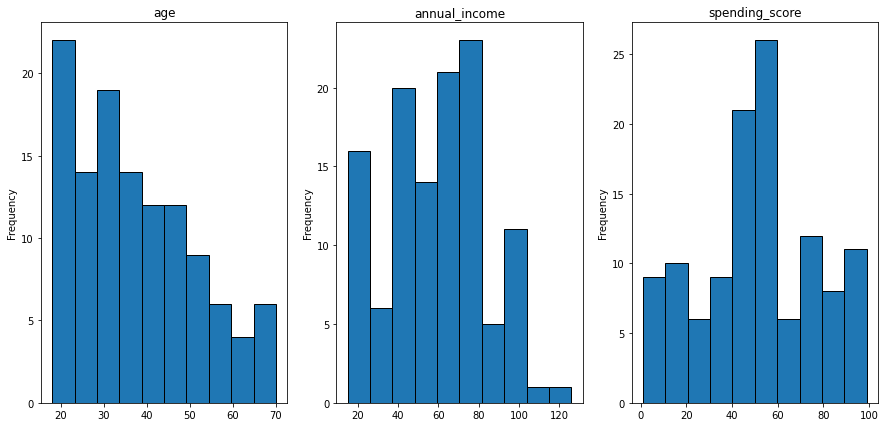

In [11]:
fig, axs = plt.subplots(1, 3, figsize=(15, 7))

for ax, col in zip(axs, train.select_dtypes('number')):
    train[col].plot.hist(ax=ax, title=col, ec='black')

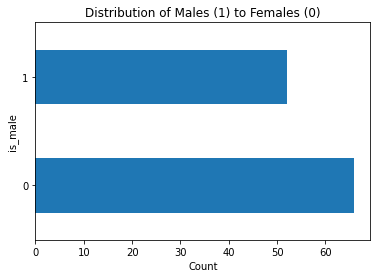

In [12]:
train.is_male.value_counts().plot.barh()
plt.title('Distribution of Males (1) to Females (0)')
plt.ylabel('is_male')
plt.xlabel('Count')
plt.show()

**Takeaways:**

- spending score is ~ normal
- age + annual income have a long tail on the right -- i.e. they are *right skewed*
- more female observations than male

### Does spending score differ across gender?

1. Viz gender against spending score
1. Stats test to confirm

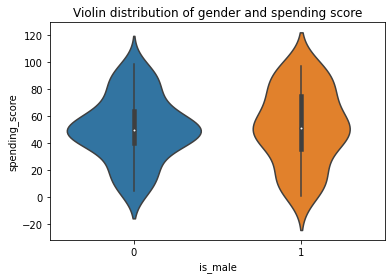

In [13]:
sns.violinplot(data=train, y='spending_score', x='is_male')
plt.title('Violin distribution of gender and spending score')
plt.show()

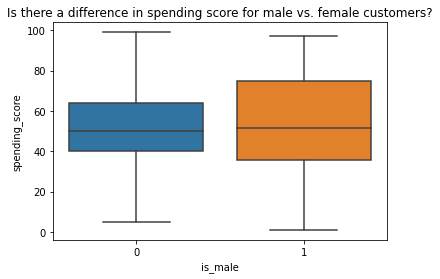

In [14]:
sns.boxplot(data=train, y='spending_score', x='is_male')
plt.title("Is there a difference in spending score for male vs. female customers?")
plt.show()

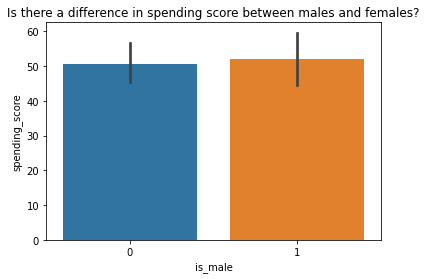

In [15]:
sns.barplot(data=train, y='spending_score', x='is_male')
plt.title("Is there a difference in spending score between males and females?")
plt.show()

**Takeaways:**

- Seems like there's not much difference in spending score.

T-test:

- one-tailed or two-tailed? 2 tailed b/c we are looking for *any* difference in means
- one-sample or two-sample? 2 sample b/c we're looking at the average spending score of 2 separate samples

**Levene's Test**: test for equal variance

- $H_0$: there is no difference in spending score variance between the two samples
- $H_a$: there is a difference in spending score variance between the two samples

In [16]:
stats.levene(
    train.query('is_male == 1').spending_score,
    train.query('is_male == 0').spending_score,
)

LeveneResult(statistic=2.1379886505631975, pvalue=0.14639412765949228)

A high pvalue (0.14) means we **fail to reject** the null hypothesis.

In [17]:
stats.ttest_ind(
    train.query('is_male == 1').spending_score,
    train.query('is_male == 0').spending_score,
    equal_var=True,
)

Ttest_indResult(statistic=0.31267242544413254, pvalue=0.7550909591158667)

We conclude there is no significant difference in spending score between Males and Females (p = 0.755).

What does `.query()` do?

In [18]:
train.query('is_male == 1').head()

,age,annual_income,spending_score,is_male
customer_id,,,,
186,30,99,97,1
114,19,64,46,1
179,59,93,14,1
172,28,87,75,1
96,24,60,52,1


In [19]:
train[train.is_male == 1].head()

,age,annual_income,spending_score,is_male
customer_id,,,,
186,30,99,97,1
114,19,64,46,1
179,59,93,14,1
172,28,87,75,1
96,24,60,52,1


**Conclusion:**

### Is there a relationship between spending score and annual income?

1. Viz annual_income by spending_score
2. Spearman's test if we want to confirm correlation (pearson's assumes normally distributed vars)

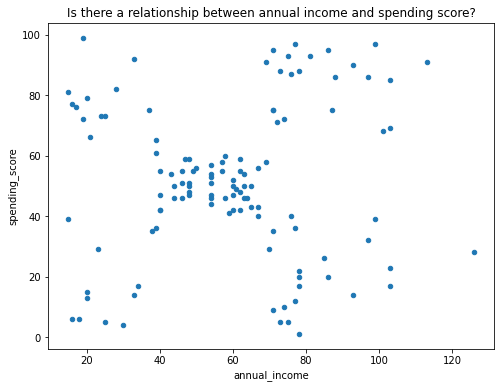

In [20]:
train.plot.scatter(
    x="annual_income",
    y="spending_score",
    title='Is there a relationship between annual income and spending score?',
    figsize=(8, 6),
)
plt.show()

**Conclusion:**

- not a linear relationship
- looks like an "X"
- looks like there might be clusters, the middle is very dense, the corners not so much

In [21]:
train.head()

,age,annual_income,spending_score,is_male
customer_id,,,,
182,32,97,86,0
49,29,40,42,0
35,49,33,14,0
186,30,99,97,1
114,19,64,46,1


Is there a relationship between age and spending score?

1. Viz age by spending_score. 
1. Create age bins and compare

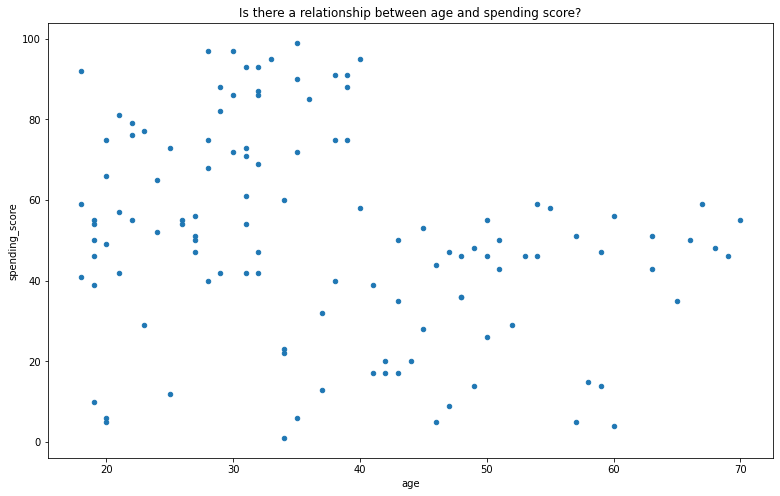

In [22]:
train.plot.scatter(y='spending_score', x='age', title='Is there a relationship between age and spending score?', figsize=(13, 8))
plt.show()

**Takeaways:**

- spending score trails off for older individuals
- younger folks seem to have higher spending scores
- after age ~ 40, max(spending score) decreases

#### How does `pd.cut()` work?

Suppose that we had an array:

In [23]:
x = pd.Series(range(1, 11))
x

0     1
1     2
2     3
3     4
4     5
5     6
6     7
7     8
8     9
9    10
dtype: int64

We can pass that array to `pd.cut()` and define the bins with a list of values:

In [24]:
pd.cut(x, bins=[0, 7, 9, 11])

0     (0, 7]
1     (0, 7]
2     (0, 7]
3     (0, 7]
4     (0, 7]
5     (0, 7]
6     (0, 7]
7     (7, 9]
8     (7, 9]
9    (9, 11]
dtype: category
Categories (3, interval[int64, right]): [(0, 7] < (7, 9] < (9, 11]]

When working with DataFrames, we can create a bin column quite easily using `pd.cut()`

In [25]:
train['age_bin'] = pd.cut(train.age, [0, 40, 80])
train.head()

,age,annual_income,spending_score,is_male,age_bin
customer_id,,,,,
182,32,97,86,0,"(0, 40]"
49,29,40,42,0,"(0, 40]"
35,49,33,14,0,"(40, 80]"
186,30,99,97,1,"(0, 40]"
114,19,64,46,1,"(0, 40]"


In [26]:
train['age_bin_short'] = pd.cut(train.age, [0, 40, 50])
train.head()

,age,annual_income,spending_score,is_male,age_bin,age_bin_short
customer_id,,,,,,
182,32,97,86,0,"(0, 40]","(0, 40]"
49,29,40,42,0,"(0, 40]","(0, 40]"
35,49,33,14,0,"(40, 80]","(40, 50]"
186,30,99,97,1,"(0, 40]","(0, 40]"
114,19,64,46,1,"(0, 40]","(0, 40]"


In [27]:
train.age_bin_short.value_counts()

(0, 40]     74
(40, 50]    22
Name: age_bin_short, dtype: int64

In [28]:
train.age_bin.value_counts()

(0, 40]     74
(40, 80]    44
Name: age_bin, dtype: int64

In [29]:
train.drop(columns=['age_bin_short'], inplace=True)

Let's take a look at the distribution of those bins:

<AxesSubplot:title={'center':'Distribution of age_bin'}>

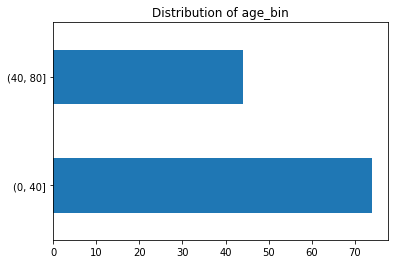

In [30]:
train.age_bin.value_counts().plot.barh(title='Distribution of age_bin')

Looks like there were not any observations with an age above 80:

In [31]:
train.age.describe()

count    118.000000
mean      37.423729
std       13.887464
min       18.000000
25%       27.000000
50%       34.500000
75%       47.750000
max       70.000000
Name: age, dtype: float64

Let's create a simple boxplot to visualize how spending score compares between these age bins:

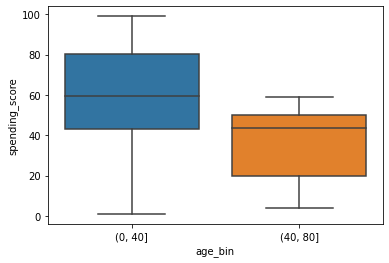

In [32]:
sns.boxplot(data=train, y='spending_score', x='age_bin')
plt.show()

In [33]:
#H0: Variances are equal
#Ha: Variances are not equal

stats.levene(
    train[train.age <= 40].spending_score,
    train[train.age > 40].spending_score,
)

LeveneResult(statistic=8.105188565471254, pvalue=0.005221578454098131)

**Conclusion:**

Our p-value is less than our alpha, so we reject the null hypothesis that the variance in spending score is the same for folks less than or equal to 40 and above 40.

(i.e. the variance is not equal)

In [34]:
stats.ttest_ind(
    train[train.age <= 40].spending_score,
    train[train.age > 40].spending_score,
    equal_var=False,
)

Ttest_indResult(statistic=5.899848364840159, pvalue=3.7357667437931227e-08)

**Conclusion:**

We reject the null hypothesis that the average spending score for folks less than or equal to 40 is the same as the average spending score for folks over 40.

In [35]:
train.head()

,age,annual_income,spending_score,is_male,age_bin
customer_id,,,,,
182,32,97,86,0,"(0, 40]"
49,29,40,42,0,"(0, 40]"
35,49,33,14,0,"(40, 80]"
186,30,99,97,1,"(0, 40]"
114,19,64,46,1,"(0, 40]"


Note that when we used `pd.cut()` we created a category object. This dtype follows its own set of rules.

In [36]:
train.dtypes

age                  int64
annual_income        int64
spending_score       int64
is_male              uint8
age_bin           category
dtype: object

The values shown are not just strings. If we try to match using a string value, its not going to find it:

In [37]:
train[train.age_bin == '(0, 40]']

,age,annual_income,spending_score,is_male,age_bin
customer_id,,,,,


Instead we have to use `pd.Interval()`:

In [38]:
train[train.age_bin == pd.Interval(0, 40)]

,age,annual_income,spending_score,is_male,age_bin
customer_id,,,,,
182,32,97,86,0,"(0, 40]"
49,29,40,42,0,"(0, 40]"
186,30,99,97,1,"(0, 40]"
114,19,64,46,1,"(0, 40]"
190,36,103,85,0,"(0, 40]"
...,...,...,...,...,...
125,23,70,29,0,"(0, 40]"
134,31,72,71,0,"(0, 40]"
130,38,71,75,1,"(0, 40]"


But if we still have access to the original unbinned data, then its probably just more straightforward to use that:

In [39]:
train[train.age <= 40]

,age,annual_income,spending_score,is_male,age_bin
customer_id,,,,,
182,32,97,86,0,"(0, 40]"
49,29,40,42,0,"(0, 40]"
186,30,99,97,1,"(0, 40]"
114,19,64,46,1,"(0, 40]"
190,36,103,85,0,"(0, 40]"
...,...,...,...,...,...
125,23,70,29,0,"(0, 40]"
134,31,72,71,0,"(0, 40]"
130,38,71,75,1,"(0, 40]"


### If we control for age, does spending score differ across annual income?

1. Viz annual income by spending score for each age bin
2. Analyze each age bin separately

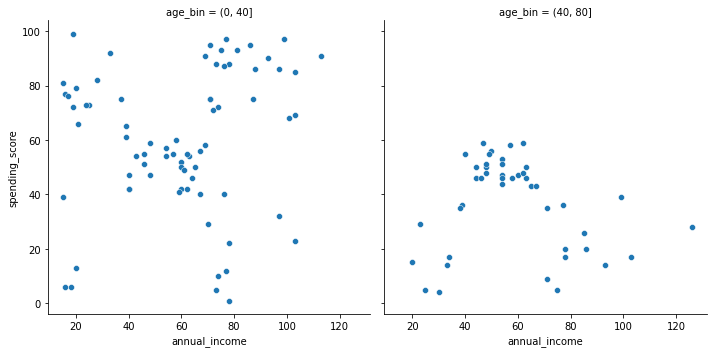

In [40]:
sns.relplot(data=train, y='spending_score', x='annual_income', col='age_bin')

**Takeaways:**

- 0 through 40 group still has an x-shape
- 40+ crowd is just the bottom half of the x

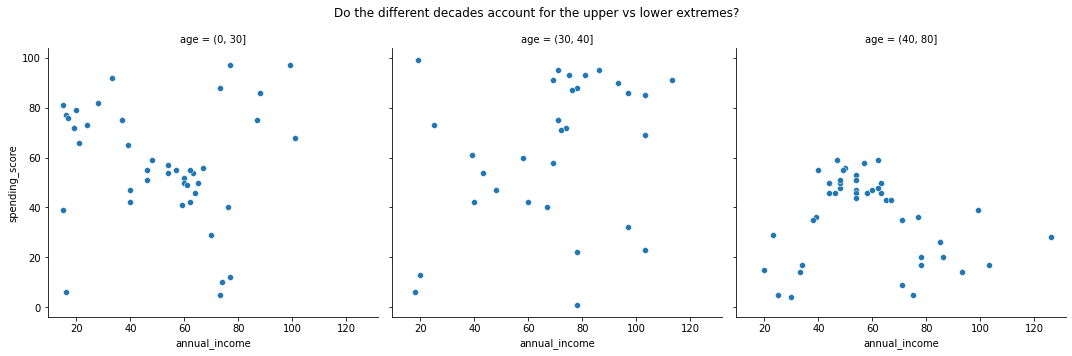

In [41]:
sns.relplot(
    data=train,
    y='spending_score',
    x='annual_income',
    col=pd.cut(train.age, bins=[0, 30, 40, 80]),
)
plt.suptitle("Do the different decades account for the upper vs lower extremes?")
plt.tight_layout()

**Takeaways:**

- 30-40 *almost* looks linear
- 0-30 *almost* looks like a negative linear relationship
- 40-80 looks quadratic

In [42]:
train.head()

,age,annual_income,spending_score,is_male,age_bin
customer_id,,,,,
182,32,97,86,0,"(0, 40]"
49,29,40,42,0,"(0, 40]"
35,49,33,14,0,"(40, 80]"
186,30,99,97,1,"(0, 40]"
114,19,64,46,1,"(0, 40]"


### Does gender explain the high income-low spending score and/or low income-low spending score in the under 40 group?

Text(0.5, 1.0, 'Does gender acccount for upper vs lower\nin the younger age group?')

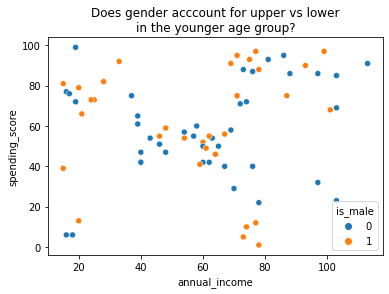

In [43]:
sns.scatterplot(
    x='annual_income',
    y='spending_score',
    data=train[train.age <= 40],
    hue='is_male',
)
plt.title("Does gender acccount for upper vs lower\nin the younger age group?")

Aside: scatterplot vs relplot

- scatter plot works with axes
- relplot works with figures

---

- seaborn is built on top of matplotlib
- every matplotlib axis lives within a figure
- a figure can have 1 or more axes in it (2+ is when we have subplots)

In [44]:
train.age_bin.value_counts()

(0, 40]     74
(40, 80]    44
Name: age_bin, dtype: int64

Does gender acccount for upper vs lower in the younger age group?



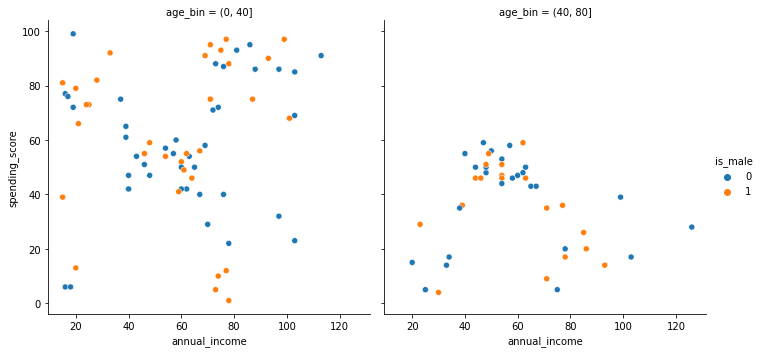

In [45]:
sns.relplot(
    x='annual_income',
    y='spending_score',
    data=train,
    hue='is_male',
    col='age_bin',
)
print("Does gender acccount for upper vs lower in the younger age group?\n")
plt.show()

**Takeaways:**

- gender isn't terribly informative in this context

In [46]:
train.head()

,age,annual_income,spending_score,is_male,age_bin
customer_id,,,,,
182,32,97,86,0,"(0, 40]"
49,29,40,42,0,"(0, 40]"
35,49,33,14,0,"(40, 80]"
186,30,99,97,1,"(0, 40]"
114,19,64,46,1,"(0, 40]"


### If we control for annual income, does spending score differ across age?

Because of the shape of annual income with spending score, I will create 3 bins of income: \[0, 40), \[40, 70), \[70, 140\]. 

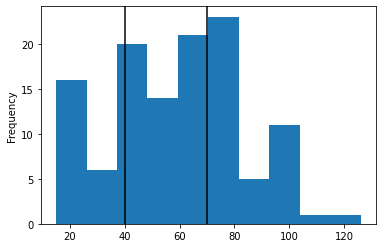

In [47]:
ax = train.annual_income.plot.hist()
ax.axvline(40, color='black')
ax.axvline(70, color='black')

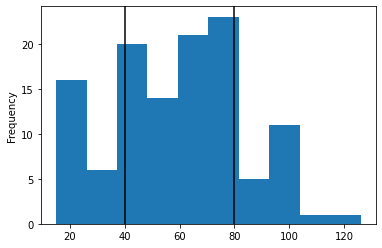

In [48]:
ax = train.annual_income.plot.hist()
ax.axvline(40, color='black')
ax.axvline(80, color='black')

In [49]:
train.head()

,age,annual_income,spending_score,is_male,age_bin
customer_id,,,,,
182,32,97,86,0,"(0, 40]"
49,29,40,42,0,"(0, 40]"
35,49,33,14,0,"(40, 80]"
186,30,99,97,1,"(0, 40]"
114,19,64,46,1,"(0, 40]"


Text(0.5, 1.0, 'How does age compare to spending score\nwithin each income bin?')

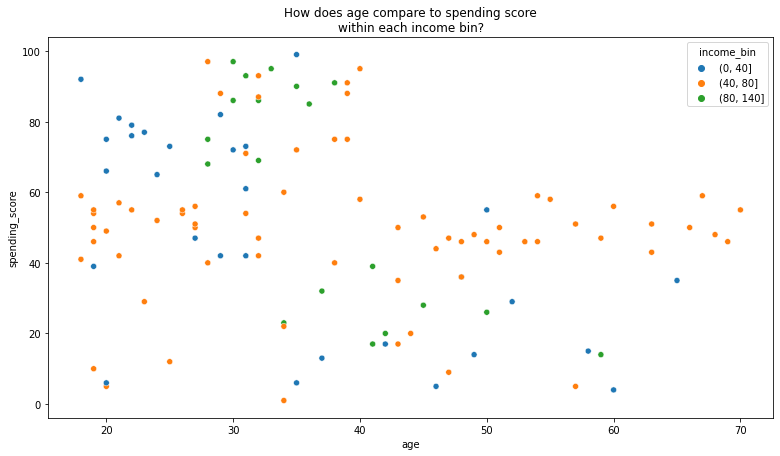

In [50]:
train['income_bin'] = pd.cut(train.annual_income, [0, 40, 80, 140])

plt.figure(figsize=(13, 7))
sns.scatterplot(
    x='age',
    y='spending_score',
    data=train,
    hue='income_bin',
)
plt.title("How does age compare to spending score\nwithin each income bin?")

Text(0.5, 1.0, 'How does age compare to spending score\nwithin each income bin?')

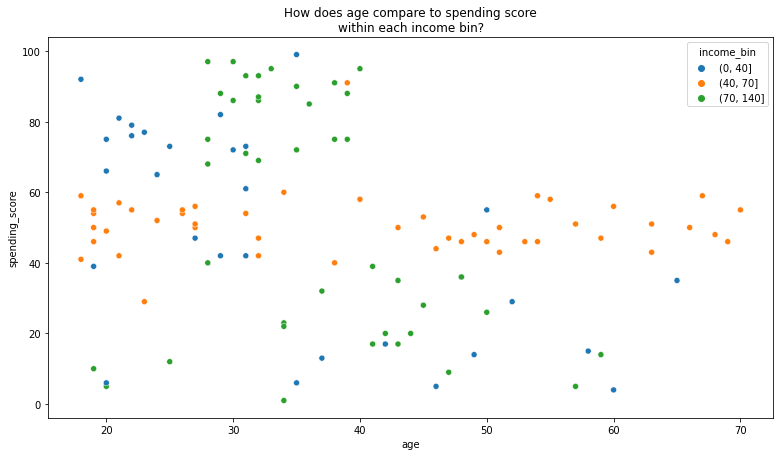

In [51]:
train['income_bin'] = pd.cut(train.annual_income, [0, 40, 70, 140])

plt.figure(figsize=(13, 7))
sns.scatterplot(
    x='age',
    y='spending_score',
    data=train,
    hue='income_bin',
)
plt.title("How does age compare to spending score\nwithin each income bin?")

Interaction of variables along with income bins


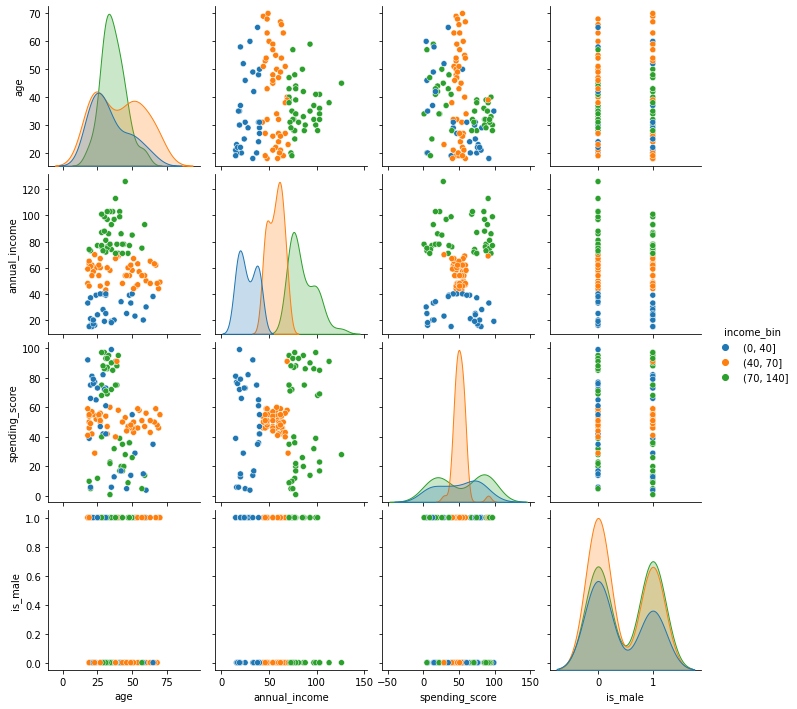

In [52]:
print("Interaction of variables along with income bins")
sns.pairplot(train, hue='income_bin')
plt.show()

**Takeaways:**

Interaction of variables along with gender


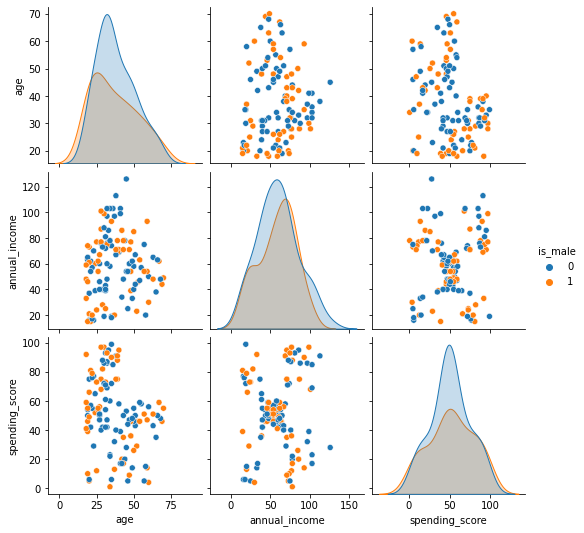

In [53]:
print("Interaction of variables along with gender")
sns.pairplot(train, hue='is_male')
plt.show()

A look at all continuous variables for each (i.e. grouped by) class of gender.

<AxesSubplot:xlabel='is_male'>

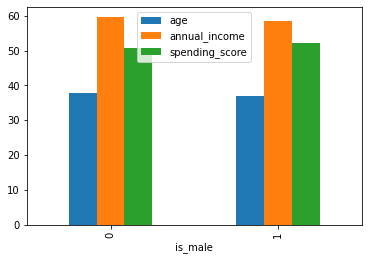

In [54]:
train.groupby('is_male').mean().plot.bar()

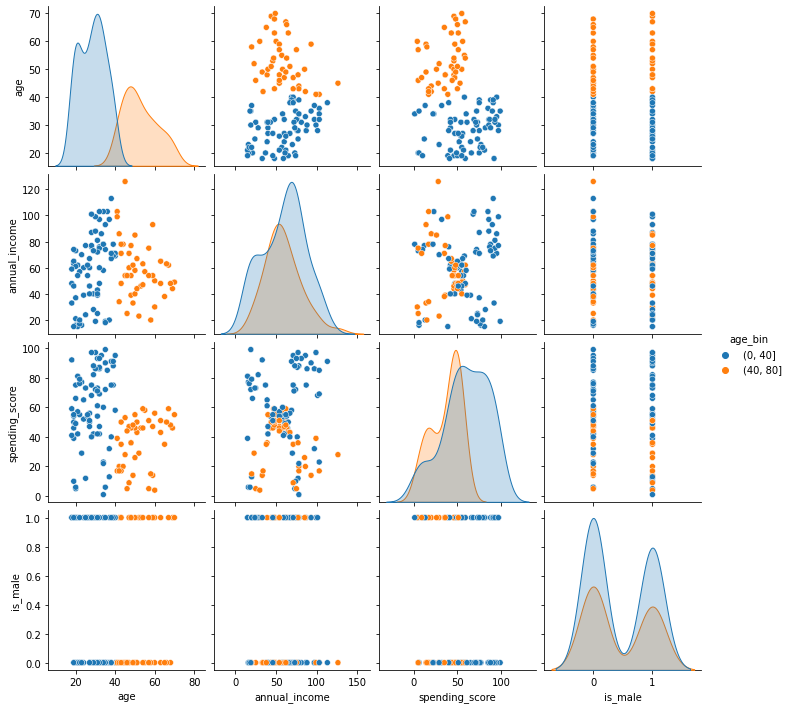

In [56]:
sns.pairplot(train, hue='age_bin')
plt.show()

## Summary

- annual income and spending score are good candidates for clustering
- older folks past some cutoff (40+) tend to not high values for spending score
- theres a good number of younger folks (30-) with low incomes and high spending scores
- gender didn't really seem to have an impact